## Generate figure 7i and 7j based on model responses from in silico experiments

In [4]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd

from matplotlib.ticker import FixedLocator
%load_ext autoreload
%autoreload 2
from openretina.utils.misc import CustomPrettyPrinter
from rgc_natstim_model.constants.plot_settings import cmap_colors as rgc_colors
from rgc_natstim_model.utils.data_handling import unPickle,makePickle
from rgc_natstim_model.constants.identifiers import dh2eh
from rgc_natstim_model.analyses.context_change_detection import bootstrap_ci,cohens_d,get_ind_roc_curve,get_roc_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pp = CustomPrettyPrinter(indent=4, max_lines=40)

In [6]:
dataset_hashes = list(dh2eh.keys())
ensemble_hashes = list(dh2eh.values())

In [19]:
base_folder = '/gpfs01/euler/data/SharedFiles/projects/Hoefling2024/'
respGen_path = base_folder+'data/simulation/response_generation/'
roc_path = base_folder+'data/simulation/roc/'

### Load data

In [12]:
## retinal ganglion cells that passed quality index filtering 
restr_data_df = pd.read_pickle(base_folder+'data/base/restr_data_df.pkl')

In [13]:
## filter retinal ganglion cells based on the model performance
rev_df = restr_data_df[(restr_data_df['single_trial_corr_avg'] > .3)]
print(len(rev_df.index))

1947


In [206]:
speeds = [4,12,20,28]

In [225]:
## a quick access to the pre-generated binned response dictionary
binned_movie_resp_dict = unPickle(respGen_path+'s{}_binned_movie_resp_dict.pkl'.format(speed))

In [18]:
## the transition types for the in-silico stimuli used to generated binned model responses
vertical_tts = np.load(roc_path+'sti1000_vertical_transitions.npy')
print(vertical_tts.shape)
print(vertical_tts[0]) # numerical codes for transition types

(1000, 4)
[ 2. -4. -2.  4.]


### Load binned responses 

In [20]:
speed=4 # 12,20,28

In [21]:
binned_movie_resp_dict = unPickle(respGen_path+'s{}_binned_movie_resp_dict.pkl'.format(speed))

### ROC

In [162]:
tpr_by_type = {}
fpr_by_type = {}
auc_by_type = {}
tpr_by_nid= {}
fpr_by_nid= {}
auc_by_nid= {}
f_by_nid= {}
f_inv_by_nid = {}
thresholds_by_nid = {}
for t in range(1, 33):
    tpr_by_nid_temp, fpr_by_nid_temp, auc_by_nid_temp, f_by_nid_temp, f_inv_by_nid_temp, thresholds_by_nid_temp = get_ind_roc_curve(
        rev_df, vertical_tts, binned_movie_resp_dict, t=t, target_transition = 4,
            above_threshold=True,
        offtarget_transition ="all"
    )
    tpr_by_nid.update(tpr_by_nid_temp)
    fpr_by_nid.update(fpr_by_nid_temp)
    auc_by_nid.update(auc_by_nid_temp)
    f_by_nid.update(f_by_nid_temp)
    f_inv_by_nid.update(f_inv_by_nid_temp)
    thresholds_by_nid.update(thresholds_by_nid_temp)
    tpr_by_type[t] = np.asarray([tpr_by_nid_temp[nid] for nid in tpr_by_nid_temp.keys()])
    fpr_by_type[t] = np.asarray([fpr_by_nid_temp[nid] for nid in fpr_by_nid_temp.keys()])
    auc_by_type[t] = np.asarray([auc_by_nid_temp[nid] for nid in auc_by_nid_temp.keys()])

In [ ]:
# makePickle(roc_path+'auc_per_type_s{}.pkl'.format(speed),auc_by_type)

In [22]:
## a quick access to pre-generated 
auc_by_type = unPickle(roc_path+'auc_per_type_s{}.pkl'.format(speed))

## fig7i

In [23]:
rc_dict_boxplot = {'figure.dpi': 300,
 'figure.figsize': [5, 2],
 'figure.frameon': False,
 'font.size': 8,
 'lines.markersize': 0.5,
 'lines.linewidth': .5,
 'lines.markeredgewidth': 0.5,
 'legend.columnspacing': 0.5,
 'legend.frameon': False,
 'legend.markerscale': 0.4,
 'legend.labelspacing': 0.1,
 'legend.handletextpad': 0,
 'legend.loc': 'lower right',
 'axes.labelpad': 1.0,
 'xtick.major.pad': 1,
 'ytick.major.pad': 1}

In [24]:
asterik_types = {
    4:[15, 27, 30,28],
    12:[15,25,27,30,28],
    20:[15,19,25,27,29,30,28],
    28:[15,19,21,23,25,27,29,30,28]
}

/tmp/ipykernel_10688/3905094737.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(range(1, 33), rotation=90, fontsize=7)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
16
17
18
19
20
21
22
23
24
25
26
29
31
32


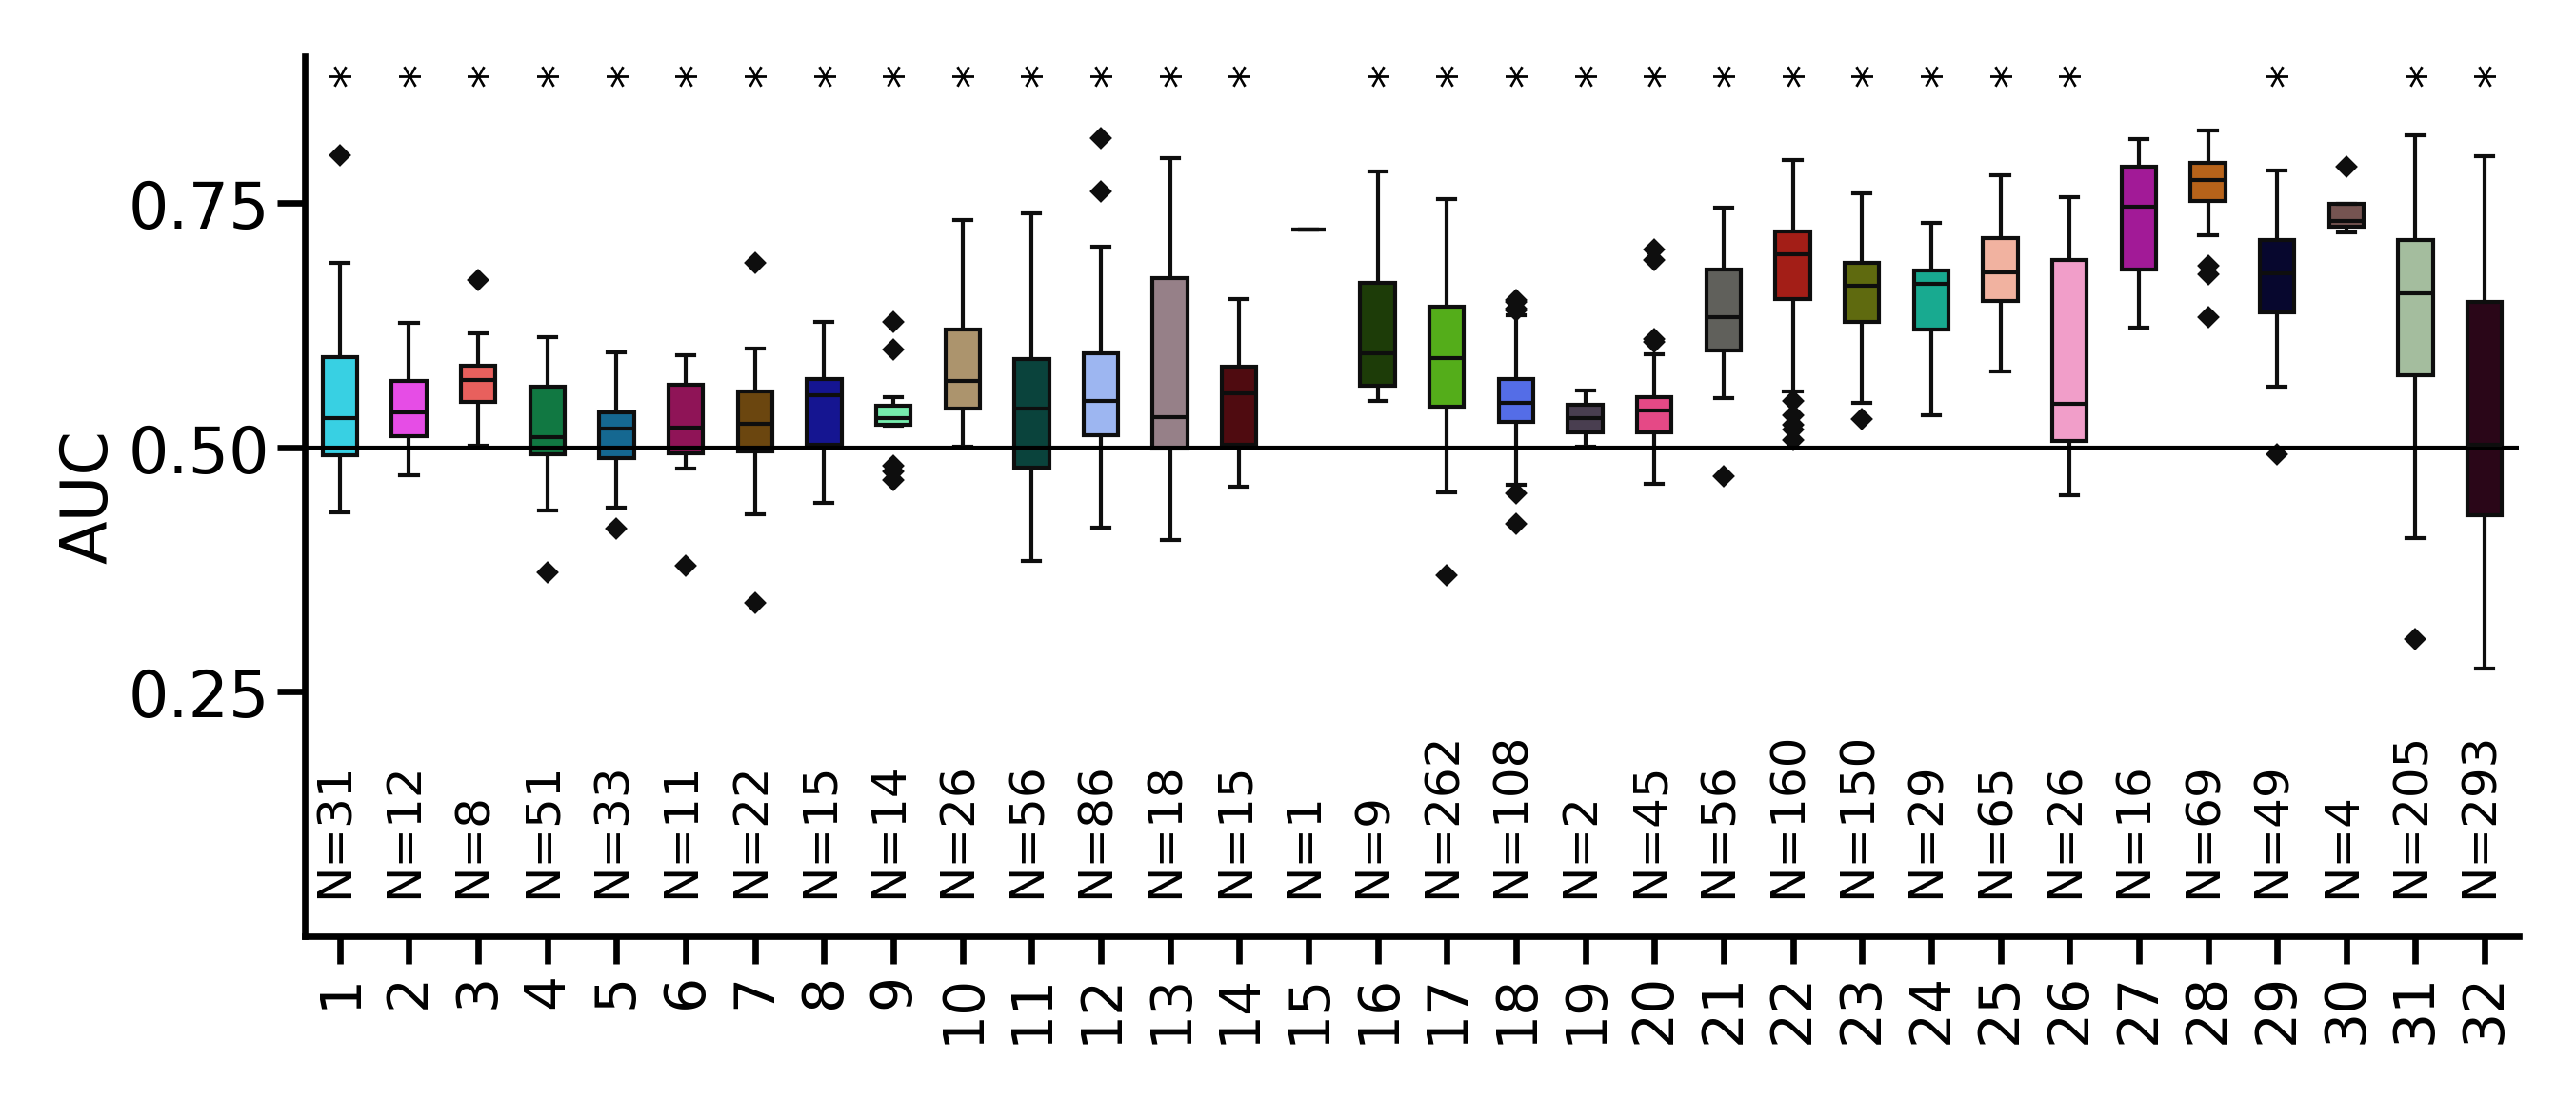

In [25]:
with mpl.rc_context(rc_dict_boxplot):
    sns.boxplot(data=[auc_by_type[t] for t in range(1, 33)], orient="v",
               palette=[rgc_colors[t-1] for t in range(1, 33)], fliersize=1, 
                width=.5,linewidth=0.5,flierprops={"marker": "D"},
                showmeans=False,meanprops={"marker": "o",
                       "markeredgecolor": "red",
                       "markersize": "2"});
    plt.gca().yaxis.set_major_locator(FixedLocator([0.25, 0.5, 0.75]))
    plt.gca().set_xticklabels(range(1, 33), rotation=90, fontsize=7)
    #plt.gca().set_xticklabels(["N = {:d}".format(len(auc_by_type[t])) for t in range(1, 33)], rotation=90)
    for t in range(1, 33):
        plt.annotate("N={}".format(len(auc_by_type[t])), xy=[t-1.4, 0.05], rotation="vertical", fontsize=6)
        if t not in asterik_types[speed]:
            print(t)
            plt.annotate("*",xy=[t-1.17,0.88],rotation='vertical',fontsize=6)
    sns.despine()
    plt.gca().axhline(0.5, color="k")
    # plt.gca().axhline(0.75, color="red",linestyle='dotted')
    # plt.gca().fill_between((26.5,27.5),1, color="red",alpha=0.2)
    # plt.xlabel("RGC group")
    plt.ylabel("AUC")
    plt.ylim(0, 0.9)
# plt.savefig('./reproduced_figS7j_s{}.jpg'.format(speed))

## fig 7j

### Generate auc_per_type for all 4 speeds

In [188]:
for speed in speeds:
    print(speed)
    binned_movie_resp_dict = unPickle(respGen_path+'s{}_binned_movie_resp_dict.pkl'.format(speed))
    tpr_by_type = {}
    fpr_by_type = {}
    auc_by_type = {}
    tpr_by_nid= {}
    fpr_by_nid= {}
    auc_by_nid= {}
    f_by_nid= {}
    f_inv_by_nid = {}
    thresholds_by_nid = {}
    for t in range(1, 33):
        tpr_by_nid_temp, fpr_by_nid_temp, auc_by_nid_temp, f_by_nid_temp, f_inv_by_nid_temp, thresholds_by_nid_temp = get_ind_roc_curve(
            rev_df, vertical_tts, binned_movie_resp_dict, t=t, target_transition = 4,
                above_threshold=True,
            offtarget_transition ="all"
        )
        tpr_by_nid.update(tpr_by_nid_temp)
        fpr_by_nid.update(fpr_by_nid_temp)
        auc_by_nid.update(auc_by_nid_temp)
        f_by_nid.update(f_by_nid_temp)
        f_inv_by_nid.update(f_inv_by_nid_temp)
        thresholds_by_nid.update(thresholds_by_nid_temp)
        tpr_by_type[t] = np.asarray([tpr_by_nid_temp[nid] for nid in tpr_by_nid_temp.keys()])
        fpr_by_type[t] = np.asarray([fpr_by_nid_temp[nid] for nid in fpr_by_nid_temp.keys()])
        auc_by_type[t] = np.asarray([auc_by_nid_temp[nid] for nid in auc_by_nid_temp.keys()])
    # makePickle(roc_path+'auc_per_type_s{}.pkl'.format(speed),auc_by_type)
    

4
12
20
28


In [26]:
## a quick access to pre-generated auc_per_type dictionaries
auc_per_type_4 = unPickle(roc_path+'auc_per_type_s4.pkl')
auc_per_type_12= unPickle(roc_path+'auc_per_type_s12.pkl')
auc_per_type_20= unPickle(roc_path+'auc_per_type_s20.pkl')
auc_per_type_28= unPickle(roc_path+'auc_per_type_s28.pkl') 

In [32]:
## calculate the mean of auc for group28 for each speed, used later in plotting
## need adjustment of shifting lines around using Adobe etc
auc_perType_28 = [auc_per_type_4[28],auc_per_type_12[28],
                  auc_per_type_20[28],auc_per_type_28[28]]
auc_perType_mean_28 = [np.mean(each) for each in auc_perType_28]

In [30]:
example_types = [1, 5, 10, 18, 20, 21, 23, 24, 28, 31, 32]

In [28]:
rc_dict_boxplot = {'figure.dpi': 300,
 'figure.figsize': [3, 2],
 'figure.frameon': False,
 'font.size': 8,
 'lines.markersize': 0.5,
 'lines.linewidth': 0.5,
 'lines.markeredgewidth': 0.5,
 'legend.columnspacing': 0.5,
 'legend.frameon': False,
 'legend.markerscale': 0.4,
 'legend.labelspacing': 0.1,
 'legend.handletextpad': 0,
 'legend.loc': 'lower right',
 'axes.labelpad': 1.0,
 'xtick.major.pad': 1,
 'ytick.major.pad': 1}

1 [4.5510753  5.56905913 4.79697378 4.1390098 ]
5 [3.86681632 3.70444689 2.70967373 2.32132253]
10 [ 5.42074832 10.42114496 11.02339208  8.38555421]
18 [ 4.54323198  6.66088591 12.28535486 10.10204565]
20 [4.38698936 6.08346502 9.9606788  8.38878528]
21 [ 7.59771773 14.73071922  7.10781951  5.46694165]
23 [ 8.99842048 15.91718168  7.02669999  6.11850472]
24 [ 8.37626689 12.50262554  5.48813357  5.34011911]
31 [ 7.70757959 10.41866193 10.58867014  8.54792688]
32 [4.27917902 3.90226271 3.63321141 3.24096588]


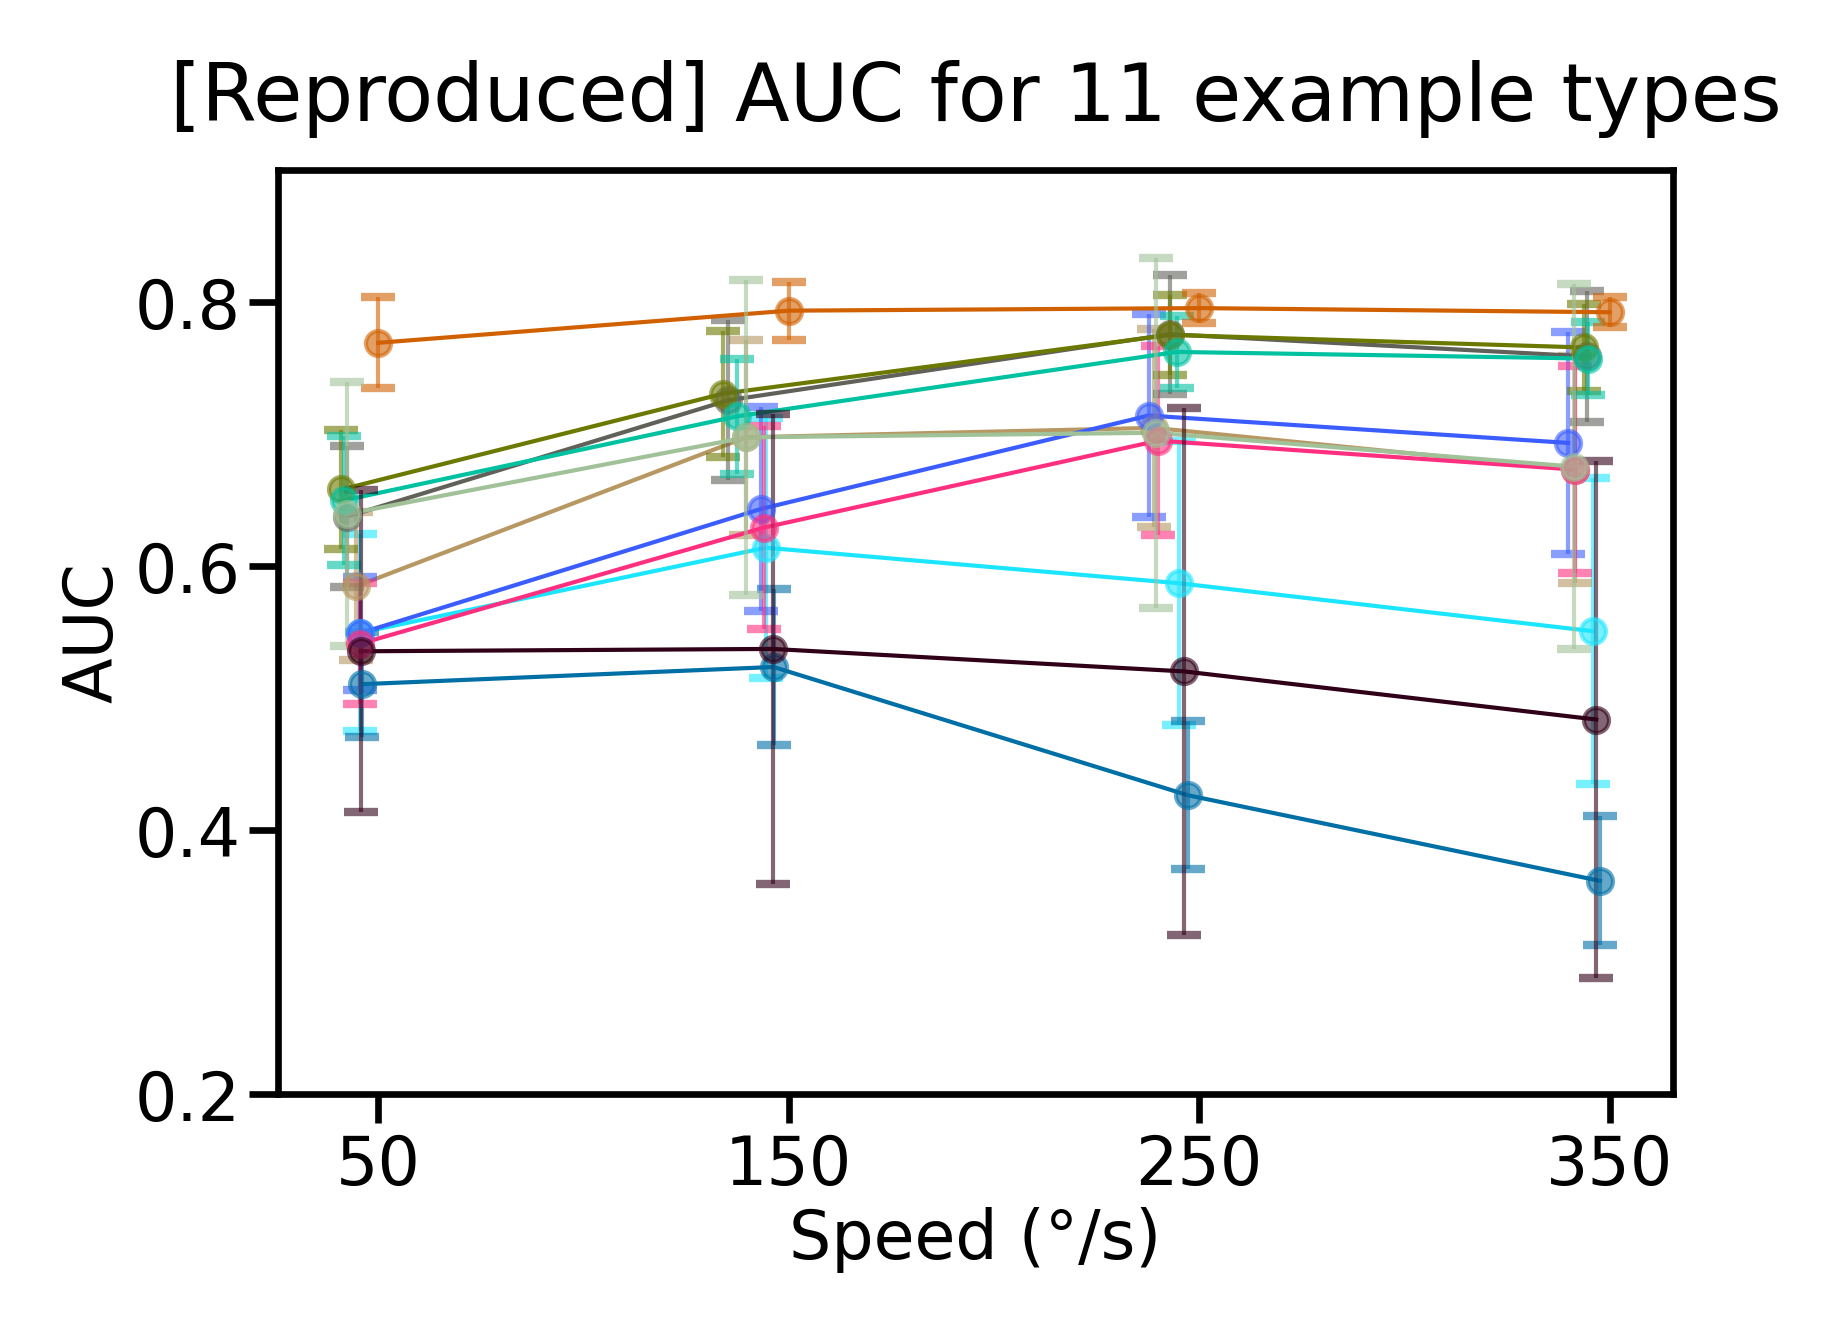

In [31]:
with mpl.rc_context(rc_dict_boxplot):
    for t in range(1,33):
        if t in example_types:
            auc_perType_list = np.array([auc_per_type_4[t],auc_per_type_12[t],
                                         auc_per_type_20[t],auc_per_type_28[t]])
            t_mean = np.mean(auc_perType_list,axis=1)
            t_sd = np.std(auc_perType_list,axis=1)
            if t!=28:
                dist_from_G28 = 1/np.abs(t_mean-auc_perType_mean_28)
                dist_from_G28 = np.where(dist_from_G28>20,np.sqrt(dist_from_G28),dist_from_G28)
                # dist_from_G28 = np.where(dist_from_G28<12,20-t,dist_from_G28)
                print(t,dist_from_G28)

            else:
                dist_from_G28 = 0
            if t<22:
                x = np.array([50,150,250,350]) - dist_from_G28
            else:
                x = np.array([50,150,250,350]) - dist_from_G28

            if t in example_types:
                plt.plot(x,t_mean,color = rgc_colors[t-1],label='G{}'.format(t))
                for i in range(4):
                    plt.errorbar(x[i],t_mean[i],yerr=t_sd[i],fmt='o',markersize='3',
                                 color=rgc_colors[t-1],
                                capsize=2, capthick=1,alpha=.6)
                
            del auc_perType_list

    plt.xticks([50,150,250,350],['50','150','250','350'])
    plt.yticks()
    plt.ylabel('AUC')
    plt.ylim([0.2,0.9])
    plt.xlabel("Speed (\N{DEGREE SIGN}/s)")
    # plt.legend(bbox_to_anchor=(1, 1),ncol=3)
    plt.title('[Reproduced] AUC for 11 example types')